![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - Deep Learning Basics</center>
### <center> Regularization Methods (Weight Decay and Dropout)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_Regularizations/MainRegularization1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(2)

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/05_Regularizations/RegularizationExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- What we have so far:
from RegularizationExampleAux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Dataset, Accuracy, Plot, Recorder, Optimizer, Adam, TrainModel
# from DeepLearningFramework.Layers        import LinearLayer, ReLULayer
# from DeepLearningFramework.Models        import SequentialModel
# from DeepLearningFramework.LossFunctions import CrossEntropyLoss
# from DeepLearningFramework.Dataset       import Dataset
# from DeepLearningFramework.Auxiliary     import Accuracy, Plot, Recorder
# from DeepLearningFramework.Optimizer     import Optimizer, Adam
# from DeepLearningFramework.Training      import TrainModel

### SgdW and AdamW - SGDM and  Adam with weight decay (not $L^2$ regularization):

In [6]:
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class SgdmW:
    def __init__(self, lr=1e-3, beta=0.9, wd=0):
        self.lr   = lr
        self.beta = beta
        self.wd   = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mV            = self.beta * mV - self.lr * mDw
        mW           += mV - self.wd * mW
        dState['mV']  = mV

        return mW, dState
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#    
class AdamW:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-8, wd=0):
        self.lr    = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps   = eps
        self.wd    = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mS            = dState.get('mS', np.zeros(mW.shape))
        ii            = dState.get('ii', 0) + 1

        mV            = self.beta1 * mV + (1 - self.beta1) * mDw
        mS            = self.beta2 * mS + (1 - self.beta2) * mDw * mDw

        mTildeV       = mV / (1 - self.beta1**ii)
        mTildeS       = mS / (1 - self.beta2**ii)

        mW           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.eps) + self.wd * mW
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii

        return mW, dState

### Get Cifar-10 dataset

In [7]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.reshape((-1, 32*32*3)) / 255
vY       = np.array(oTorchTrainSet.targets)
mX.shape, vY.shape, lClasses

Files already downloaded and verified


((50000, 3072),
 (50000,),
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

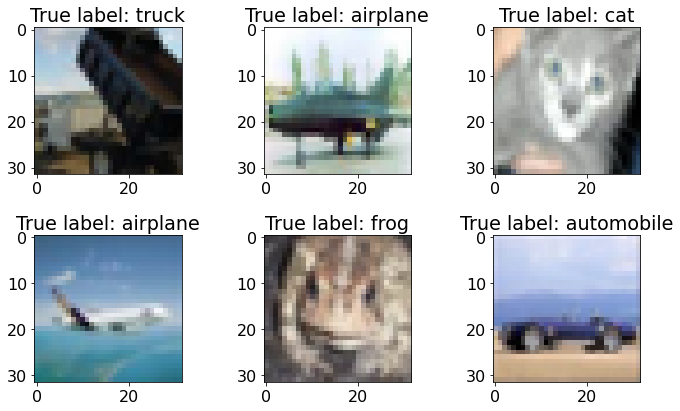

In [8]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (32, 32, 3)))
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [9]:
vMean = np.mean(mX, axis=0)
vStd  = np.std (mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [10]:
from sklearn.model_selection import train_test_split

Ntrain = 45000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

batchSize     = 512
oTrainSet     = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet       = Dataset(mValX.T,   vValY,   2*batchSize)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((45000, 3072), (45000,), (5000, 3072), (5000,))

###  Define a model:

In [11]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(32*32*3, 200),
        ReLULayer(),
        LinearLayer(200, 100),
        ReLULayer(),
        LinearLayer(100, 50),
        ReLULayer(),
        LinearLayer(50, 10),
    ])
    
    return oModel

### Train without weight decay:

<IPython.core.display.Javascript object>


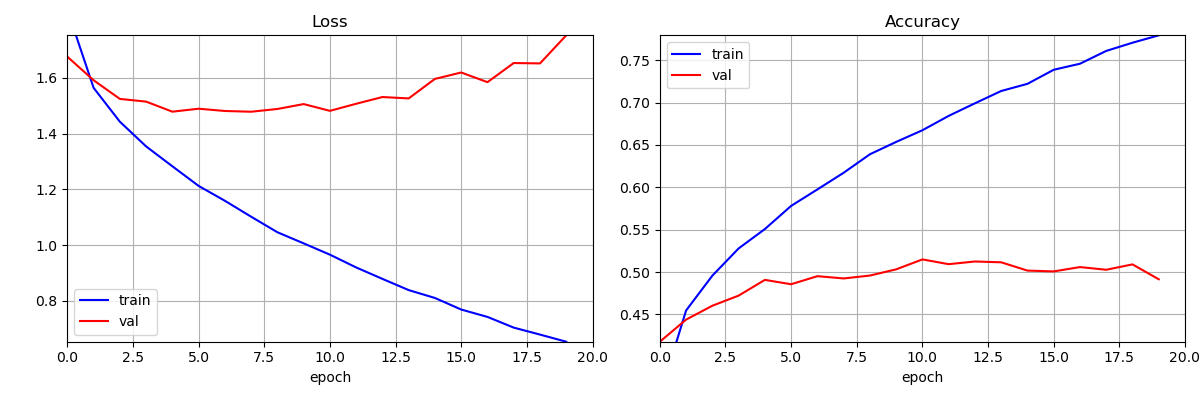

Epoch   0: | Train loss: 1.84463 | Val loss: 1.67578 | Train Accuracy: 0.3539 | Val Accuracy: 0.4177 | epoch time: 7.270 |
Epoch   1: | Train loss: 1.56408 | Val loss: 1.59127 | Train Accuracy: 0.4546 | Val Accuracy: 0.4438 | epoch time: 7.555 |
Epoch   2: | Train loss: 1.44252 | Val loss: 1.52436 | Train Accuracy: 0.4957 | Val Accuracy: 0.4602 | epoch time: 7.328 |
Epoch   3: | Train loss: 1.35389 | Val loss: 1.51462 | Train Accuracy: 0.5279 | Val Accuracy: 0.4722 | epoch time: 7.249 |
Epoch   4: | Train loss: 1.28261 | Val loss: 1.47853 | Train Accuracy: 0.5507 | Val Accuracy: 0.4907 | epoch time: 6.871 |
Epoch   5: | Train loss: 1.21215 | Val loss: 1.48916 | Train Accuracy: 0.5781 | Val Accuracy: 0.4856 | epoch time: 7.562 |
Epoch   6: | Train loss: 1.15886 | Val loss: 1.48100 | Train Accuracy: 0.5975 | Val Accuracy: 0.4951 | epoch time: 7.445 |
Epoch   7: | Train loss: 1.10169 | Val loss: 1.47835 | Train Accuracy: 0.6172 | Val Accuracy: 0.4924 | epoch time: 7.317 |
Epoch   8: | Tra

In [12]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModel()
oOptim = Optimizer(AdamW(lr=5e-4, beta1=0.9, beta2=0.99, wd=0))
TrainModel(oModel, oTrainSet, oValSet, 20, oOptim)

### Train with weight decay:

<IPython.core.display.Javascript object>


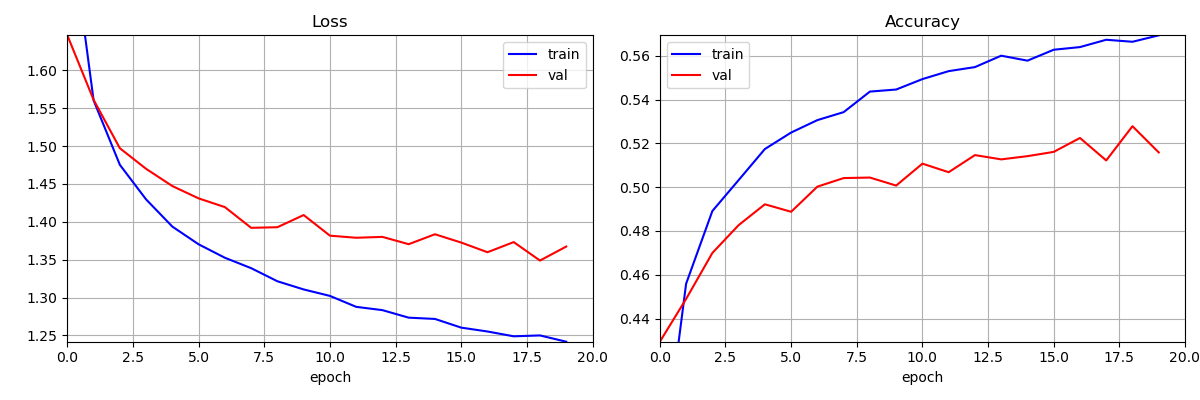

Epoch   0: | Train loss: 1.82196 | Val loss: 1.64619 | Train Accuracy: 0.3627 | Val Accuracy: 0.4294 | epoch time: 7.027 |
Epoch   1: | Train loss: 1.56029 | Val loss: 1.56106 | Train Accuracy: 0.4559 | Val Accuracy: 0.4490 | epoch time: 6.865 |
Epoch   2: | Train loss: 1.47520 | Val loss: 1.49710 | Train Accuracy: 0.4891 | Val Accuracy: 0.4700 | epoch time: 6.973 |
Epoch   3: | Train loss: 1.42952 | Val loss: 1.46991 | Train Accuracy: 0.5032 | Val Accuracy: 0.4827 | epoch time: 6.879 |
Epoch   4: | Train loss: 1.39363 | Val loss: 1.44717 | Train Accuracy: 0.5174 | Val Accuracy: 0.4922 | epoch time: 6.802 |
Epoch   5: | Train loss: 1.37025 | Val loss: 1.43090 | Train Accuracy: 0.5249 | Val Accuracy: 0.4888 | epoch time: 6.831 |
Epoch   6: | Train loss: 1.35251 | Val loss: 1.41936 | Train Accuracy: 0.5306 | Val Accuracy: 0.5002 | epoch time: 6.887 |
Epoch   7: | Train loss: 1.33877 | Val loss: 1.39204 | Train Accuracy: 0.5343 | Val Accuracy: 0.5042 | epoch time: 6.865 |
Epoch   8: | Tra

In [13]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModel()
oOptim = Optimizer(AdamW(lr=5e-4, beta1=0.9, beta2=0.99, wd=2e-3))
TrainModel(oModel, oTrainSet, oValSet, 20, oOptim)

### Dropout layer:
Forwrad:
$$\boldsymbol{z}=\frac{1}{p}\boldsymbol{x}\odot\boldsymbol{m}=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{x}$$
where $\boldsymbol{m}$ is a mask (same size as $\boldsymbol{x}$)
such that each $\boldsymbol{m}\left[i\right]\sim\text{Bernoulli}\left(p\right)$

Backward:
$$
\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{h}\right\rangle =\left\langle \frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle 
$$
$$
\implies\boxed{\nabla_{\boldsymbol{x}}L=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L=\frac{1}{p}\nabla_{\boldsymbol{z}}L\odot\boldsymbol{m}}
$$


In [14]:
class DropoutLayer:
    def __init__(self, p=0.5):
        self.dGrads = {}
        self.p      = p

    #-- Train time:
    def Forward(self, mX):
        self.mMask = (np.random.rand(*mX.shape) < self.p).astype(float) / self.p
        mZ         = mX * self.mMask

        return mZ

    #-- Test time:
    def Predict(self, mX):
        return mX
    
    def Backward(self, mDz):
        mDx   = mDz * self.mMask

        return mDx

###  We need to track if we training or testing:

In [15]:
class SequentialModel:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        self.train   = False

    def Forward(self, mX):
        for oLayer in self.lLayers:
            if self.train == False and hasattr(oLayer, 'Predict'):
                #-- Test time:
                mX = oLayer.Predict(mX)
            else:
                #-- Train time:
                mX = oLayer.Forward(mX)
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

In [16]:
import time

def TrainLoop(oModel, oTrainData, oOptim):

    epochLoss    = 0
    epochAcc     = 0
    oModel.train = True
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters
        oOptim.Step(oModel)

        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')

    epochLoss /= ii + 1
    epochAcc  /= ii + 1

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValData):

    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    oModel.train = False
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)

        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)

    epochLoss /= ii + 1
    epochAcc  /= ii + 1

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainModel(oModel, oTrainData, oValData, numEpochs, oOptim):

    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, oOptim)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()

        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')


### Define the same architecture but with dropouts:

In [17]:
def GetModelWithDropout():
    oModel = SequentialModel([
        LinearLayer(32*32*3, 200),
        ReLULayer(),
        DropoutLayer(p=4/5),
        LinearLayer(200, 100),
        ReLULayer(),
        DropoutLayer(p=4/5),
        LinearLayer(100, 50),
        ReLULayer(),
        DropoutLayer(p=9/10),
        LinearLayer(50, 10),
    ])
    
    return oModel

<IPython.core.display.Javascript object>


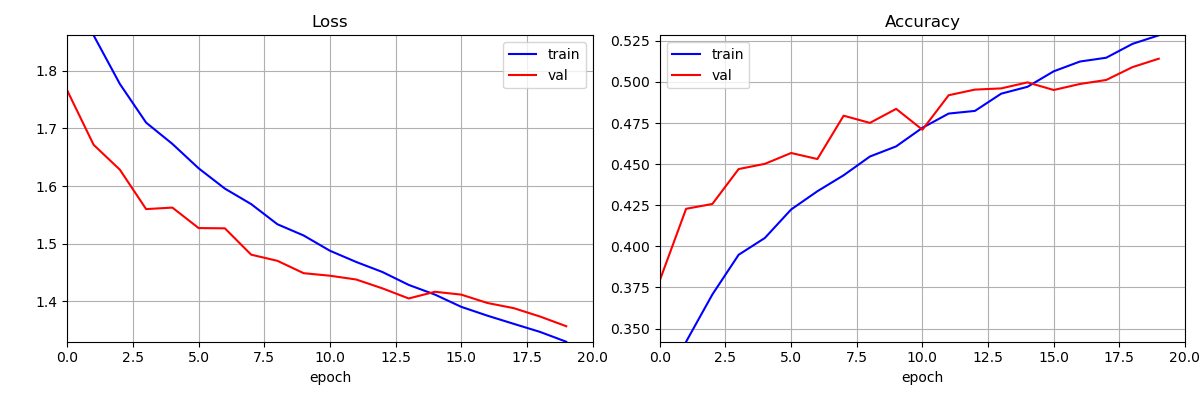

Epoch   0: | Train loss: 2.10471 | Val loss: 1.76539 | Train Accuracy: 0.2696 | Val Accuracy: 0.3794 | epoch time: 7.247 |
Epoch   1: | Train loss: 1.86155 | Val loss: 1.67164 | Train Accuracy: 0.3420 | Val Accuracy: 0.4229 | epoch time: 7.334 |
Epoch   2: | Train loss: 1.77719 | Val loss: 1.62840 | Train Accuracy: 0.3707 | Val Accuracy: 0.4258 | epoch time: 7.185 |
Epoch   3: | Train loss: 1.71006 | Val loss: 1.56001 | Train Accuracy: 0.3949 | Val Accuracy: 0.4470 | epoch time: 7.362 |
Epoch   4: | Train loss: 1.67316 | Val loss: 1.56263 | Train Accuracy: 0.4051 | Val Accuracy: 0.4502 | epoch time: 7.006 |
Epoch   5: | Train loss: 1.63080 | Val loss: 1.52710 | Train Accuracy: 0.4224 | Val Accuracy: 0.4568 | epoch time: 7.071 |
Epoch   6: | Train loss: 1.59555 | Val loss: 1.52664 | Train Accuracy: 0.4335 | Val Accuracy: 0.4531 | epoch time: 7.033 |
Epoch   7: | Train loss: 1.56872 | Val loss: 1.48094 | Train Accuracy: 0.4432 | Val Accuracy: 0.4795 | epoch time: 7.057 |
Epoch   8: | Tra

In [18]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModelWithDropout()
oOptim = Optimizer(AdamW(lr=5e-4, beta1=0.9, beta2=0.99, wd=0))
TrainModel(oModel, oTrainSet, oValSet, 20, oOptim)

### Dropout + weight decay:

<IPython.core.display.Javascript object>


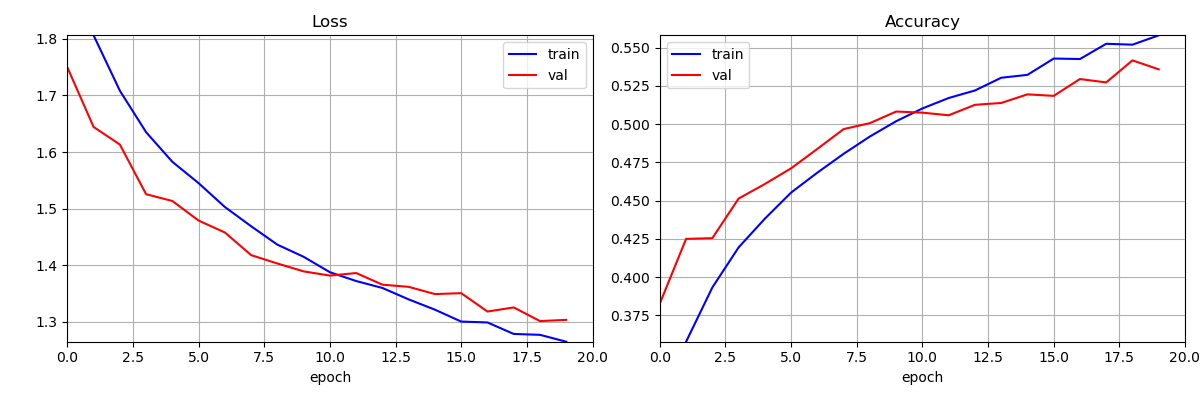

Epoch   0: | Train loss: 2.09554 | Val loss: 1.74978 | Train Accuracy: 0.2723 | Val Accuracy: 0.3828 | epoch time: 7.363 |
Epoch   1: | Train loss: 1.80631 | Val loss: 1.64433 | Train Accuracy: 0.3578 | Val Accuracy: 0.4250 | epoch time: 7.498 |
Epoch   2: | Train loss: 1.70843 | Val loss: 1.61326 | Train Accuracy: 0.3933 | Val Accuracy: 0.4255 | epoch time: 7.547 |
Epoch   3: | Train loss: 1.63504 | Val loss: 1.52542 | Train Accuracy: 0.4195 | Val Accuracy: 0.4514 | epoch time: 7.496 |
Epoch   4: | Train loss: 1.58265 | Val loss: 1.51343 | Train Accuracy: 0.4383 | Val Accuracy: 0.4609 | epoch time: 7.386 |
Epoch   5: | Train loss: 1.54494 | Val loss: 1.47880 | Train Accuracy: 0.4553 | Val Accuracy: 0.4712 | epoch time: 8.401 |
Epoch   6: | Train loss: 1.50278 | Val loss: 1.45775 | Train Accuracy: 0.4684 | Val Accuracy: 0.4839 | epoch time: 7.974 |
Epoch   7: | Train loss: 1.46877 | Val loss: 1.41773 | Train Accuracy: 0.4807 | Val Accuracy: 0.4968 | epoch time: 8.483 |
Epoch   8: | Tra

In [19]:
%matplotlib notebook

np.random.seed(1)
oModel = GetModelWithDropout()
oOptim = Optimizer(AdamW(lr=1e-3, beta1=0.9, beta2=0.99, wd=1e-3))
TrainModel(oModel, oTrainSet, oValSet, 20, oOptim)